In [1]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

--2022-12-17 15:21:34--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2022-12-17 15:21:34--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  93.7MB/s    in 0.8s    

2022-12-17 15:21:35 (93.7 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [5]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.4 MB/s eta 0:00:00a 0:00:01


In [52]:
!pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 427.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 13.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 3.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1
    Uninstalling torchvision-0.14.1:
      Successfully uninstalled torchvision-0.14.1


In [49]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 72.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 10.7 MB/s eta 0:00:00


In [51]:
!source cuda11.1

/bin/bash: cuda11.1: No such file or directory


In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/spa2138/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import zipfile
import os
path_to_zip_file = os.getcwd() + "/trainingandtestdata.zip"
directory_to_extract_to = os.getcwd() + "/data"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [1]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from random import sample

import numpy as np
import os
import pandas as pd
import pickle
import re

from math import floor
from gensim.models import KeyedVectors
from torch.nn.utils.rnn import pack_sequence, PackedSequence
from torch.optim.lr_scheduler import CyclicLR

import torch.nn as tnn
import torch as th
import numpy as np
from tqdm import tqdm
import copy



2022-12-17 16:22:59.219378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 16:22:59.392441: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-17 16:23:00.234310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-17 16:23:00.234395: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer

#### Loading Data

In [7]:
os.getcwd()

'/home/spa2138'

In [8]:
input_file = '/home/spa2138/data/training.1600000.processed.noemoticon.csv'

In [20]:
columns = ["target", "ids", "date", "flag", "user", "text"]
data = pd.read_csv(input_file, encoding = "ISO-8859-1", header = None, names = columns)

## Preprocessing Data

In [21]:
def index_data_by_date(data, string_tz = "PDT"):
    timezone = 'US/Pacific' if "PDT" or "PT" in string_tz else "UTC"
    data.date = data.date.str.replace(string_tz, "")
    data.date = data.date.astype("datetime64[ns]")
    data.index = data.date
    data.drop(["date"], axis = 1, inplace = True)
    data.index = data.index.tz_localize(timezone)
    return data

In [164]:
CLEANING_REGEX = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
NEGATIONS_DICT = {
                "isn't":"is not", "aren't":"are not", "wasn't":"was not", 
                "weren't": "were not", "haven't":"have not","hasn't":"has not",
                "hadn't":"had not","won't":"will not", "wouldn't":"would not", 
                "don't":"do not", "doesn't":"does not", "didn't":"did not",
                "can't":"can not","couldn't":"could not",
                "shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"
                }

In [160]:
def get_cleaned_text(text, stop_words, stemmer, stem = False):    
    neg_pattern = re.compile(r'\b(' + '|'.join(NEGATIONS_DICT.keys()) + r')\b')    
    text = re.sub(CLEANING_REGEX, " ", str(text).lower()).strip()
    text = neg_pattern.sub(lambda x: NEGATIONS_DICT[x.group()], text)
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
                continue
            tokens.append(token)    
    text = " ".join(tokens)
    text = re.sub("n't", "not", text)
    return re.sub("'s", "is", text)

In [36]:
def text_to_sequence(texts, tokenizer):
    tokenizer = tokenizer()
    tokenizer.fit_on_texts(texts)
    return tokenizer.texts_to_sequences(texts), tokenizer

In [41]:
def split_X_and_Y(sequence):
    X = [0]    
    Y = [sequence[0]]
    for idx, token in enumerate(sequence[:-1]):
        X.append(token)
        Y.append(sequence[idx + 1])
    return pd.Series({"X": X, "Y": Y})

In [162]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [23]:
min_tweets = 20

In [24]:
data.drop(["target", "flag", "ids"], axis = 1, inplace = True)
users = data.groupby(by = "user").apply(len) > min_tweets
data = data[data.user.isin(users[users].index)]
data = index_data_by_date(data)

In [29]:
data["cleaned_text"] = data.text.apply(lambda x: get_cleaned_text(x, stop_words, stemmer))

In [30]:
data.drop_duplicates(subset = ["cleaned_text"], keep = False, inplace = True)

In [32]:
sequences, tokenizer = text_to_sequence(data.cleaned_text, Tokenizer)
data["sequence"] = sequences
data = data[data.sequence.map(lambda x: len(x)) > 0]    

In [34]:
data = data.merge(data.sequence.apply(lambda x: split_X_and_Y(x)), left_index = True, right_index = True)

### Saving Processed Data to pickle file

In [35]:
processed_data = "/home/spa2138/data/processed_data.pkl"
data.to_pickle(processed_data)

In [39]:
word2idx_file = "/home/spa2138/data/tokenizer_keys_short.pkl"
with open(word2idx_file, "wb") as f:
    pickle.dump(tokenizer.word_index, f, pickle.HIGHEST_PROTOCOL)

In [44]:
word2idx = tokenizer.word_index

In [54]:
processed_data = "/home/spa2138/data/processed_data.pkl"
word2idx_file = "/home/spa2138/data/tokenizer_keys.pkl"
data = pd.read_pickle(processed_data)
with open(word2idx_file, "rb") as f:
    word2idx = pickle.load(f)

### Dividing data into Local and Remote

In [33]:
local_share = 0.2
unique_users = data.user.unique()
idx_share = int(local_share*unique_users.shape[0])
local_users = unique_users[:idx_share]
remote_users = unique_users[idx_share:]
local_data = data[data.user.isin(local_users)]
remote_data = data[data.user.isin(remote_users)]

# Training Phase

In [13]:
GOOGLE_W2V = "/home/spa2138/data/GoogleNews-vectors-negative300.bin.gz"
HISTORY = lambda param: {
                "train_acc": copy.deepcopy(param),
                "topk_train_acc": copy.deepcopy(param),
                "train_loss": copy.deepcopy(param), 
                "val_acc": copy.deepcopy(param), 
                "topk_val_acc": copy.deepcopy(param),
                "val_loss": copy.deepcopy(param),
                }

In [78]:
def extend_data(X, Y, context_size):
    new_X = []
    new_Y = []
    for idx, x in enumerate(X):
        y = Y[idx]        
        for idx2, word in enumerate(x):
            if idx2 < 5:                
                new_X.append(pad_sequences([x[:idx2 + 1]], maxlen = context_size)[0])
            else:                
                new_X.append(x[idx2 - context_size + 1: idx2 + 1])
            new_Y.append(np.array(y[idx2], dtype = "int32"))
    new_X = np.vstack(new_X)
    new_Y = np.array(new_Y).astype(np.int32)
    return new_X, new_Y

In [6]:
import numpy as np
import torch


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience = 5, verbose = False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf


    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0


    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Storing model ...')        
        self.best_model = {key: value.clone() 
                                for key, value in model.state_dict().items()}
        self.val_loss_min = val_loss

In [195]:
class bidirectional_LSTM(tnn.Module):
    def __init__(self, context_size, V, D, word2idx, word2vec, hidden_nodes = 128,
                n_rnn_layers = 1,
                activation_last_layer = tnn.functional.log_softmax,     
                dropout = 0.2,
                learning_rate = 10**(-3),                
                loss_fun = tnn.NLLLoss()):                            
        super(bidirectional_LSTM, self).__init__()
        self.word2vec = word2vec
        self.context_size = context_size
        self.V = V        
        self.D = D
        self.word2idx = word2idx
        self.idx2word = {value: key for key, value in word2idx.items()}
        self.hidden_nodes = hidden_nodes
        self.n_fc_layer1 = 8*hidden_nodes        
        self.n_rnn_layers = n_rnn_layers
        self.activation_last_layer = activation_last_layer        
        self.dropout = dropout
        self.lr = learning_rate
        self.loss_fun = loss_fun
        self._build()       


    def _build(self):                           
        self.embedding = tnn.Embedding.from_pretrained(embed_vocab(self.word2idx, 
                                    self.V, self.D, self.word2vec), freeze = True)        
        self.bi_lstm = tnn.LSTM(input_size = self.D, 
                            hidden_size = self.hidden_nodes,
                            num_layers = self.n_rnn_layers, bias = True, 
                            batch_first = True, dropout = self.dropout, 
                            bidirectional = True)
        self.fc_layer = tnn.Linear(2*self.hidden_nodes, self.V)
        self.relu_layer = tnn.ReLU()

    
    def _init_hidden(self, batch_size):
        h0 = th.autograd.Variable(th.zeros(2*self.n_rnn_layers, batch_size, 
                                                        self.hidden_nodes))
        c0 = th.autograd.Variable(th.zeros(2*self.n_rnn_layers, batch_size, 
                                                        self.hidden_nodes))
        device = th.device('cuda' if th.cuda.is_available() else 'cpu')
        h0 = h0.to(device)
        c0 = h0.to(device)
        return [h0, c0]

    
    def _sequence_to_text(self, seq):
        return " ".join([self.idx2word[int(idx)] for idx in seq])

    
    def forward(self, X):
        embedded = self.embedding(X)        
        if hasattr(X, "location"):
            for idx, hidden in enumerate(self.h_lstm):            
                self.h_lstm[idx] = hidden.send(X.location)            
        output, _ = self.bi_lstm(embedded, self.h_lstm)        
        output = output.transpose(1, 2)
        output = self.relu_layer(output[:, :, -1])        
        output = self.fc_layer(output)
        return output
    
    
    def _score_from_outputs(self, outputs, Y, k = 1):                
        preds = tnn.functional.softmax(outputs, dim = 1).topk(k, dim = 1)[1]
        preds = preds.view([-1]) if k == 1 else preds
        n_correct = 0
        for outputs, target in zip(preds, Y):
            if k > 1:
                for output in outputs:                               
                    if th.equal(target.long(), output.long()):
                        n_correct += 1
                        break
            elif k == 1 and th.equal(target.long(), outputs.long()):
                n_correct += 1                    
        return n_correct / len(Y)


    def score_and_loss(self, X, Y, loss_fun, local, batch_size = 1024):
        n_batches = len(X) // batch_size
        if n_batches == 0:
            self.h_lstm = self._init_hidden(len(X))
            outputs = self.forward(X).view(len(X), -1)            
            logits = self.activation_last_layer(outputs, dim = 1)
            loss = loss_fun(logits, Y.long())
            if not local:
                loss = loss.get()                
            loss_value = loss.item()
            return self._score_from_outputs(outputs, Y), loss_value
        accuracy = 0
        loss_value = 0
        for j in range(n_batches):
            self.h_lstm = self._init_hidden(batch_size)
            X_batch = X[j*batch_size:(j*batch_size + batch_size)]
            Y_batch = Y[j*batch_size:(j*batch_size + batch_size)]
            outputs = self.forward(X_batch)
            logits = self.activation_last_layer(outputs, dim = 1)
            loss = loss_fun(logits, Y_batch.long())
            if not local:
                loss = loss.get()
            loss_value += loss.item()
            accuracy += self._score_from_outputs(outputs, Y_batch)
        return accuracy / n_batches, loss_value / n_batches

    
    def score_topk(self, X, Y, local, topk_pred, batch_size = 1024):
        n_batches = len(X) // batch_size
        if n_batches == 0:
            self.h_lstm = self._init_hidden(len(X))
            outputs = self.forward(X).view(len(X), -1)
            return self._score_from_outputs(outputs, Y, topk_pred)
        accuracy = 0
        loss_value = 0
        for j in range(n_batches):
            self.h_lstm = self._init_hidden(batch_size)
            X_batch = X[j*batch_size:(j*batch_size + batch_size)]
            Y_batch = Y[j*batch_size:(j*batch_size + batch_size)]
            outputs = self.forward(X_batch)
            accuracy += self._score_from_outputs(outputs, Y_batch, topk_pred)
        return accuracy / n_batches

    
    def fit(self, X, Y, optimizer, batch_size = 64, epochs = 10, local = True,
            validation_split = 0.2, batch_print_epoch = 1, verbose = True, 
            patience = 10, topk_pred = None):        
        n_samples = len(X)
        optimizer = optimizer(self.parameters(), lr = self.lr)        
        if validation_split and len(X) > batch_size:
            val_size = int(n_samples * (1 - validation_split))
            X_train, Y_train = X[:val_size], Y[:val_size]
            X_test, Y_test = X[val_size:], Y[val_size:]
        else:
            X_train, Y_train = X.copy(), Y.copy()
            X_test, Y_test = X.copy(), Y.copy()
        n_batches = len(X_train) // batch_size            
        scheduler = CyclicLR(optimizer, self.lr / 1000, self.lr, 
                    step_size_up = 4000)
        batch_string = ("Running loss per batch epoch {}/{} on batch " + 
                        "{}/{}: {:.3f}\t Running accuracy: {:.3f} Epoch done:{:.4f}%").format
        epoch_string = ("Epoch {}/{}  " + 
                        "Training loss: {:.3f}   " +
                        "Training accuracy: {:.3f}\t" + 
                        "Validation loss: {:.3f}  " + 
                        "Validation accuracy: {:.3f}").format
        loss_fun = self.loss_fun if local else self.loss_fun.send(X.location)
        history = HISTORY([])
        early_stopping = EarlyStopping(patience = patience, verbose = False)        
        for epoch in range(epochs):
            running_loss = 0
            running_acc = 0
            for j in range(n_batches):
                self.h_lstm = self._init_hidden(batch_size)                
                X_batch = X_train[j*batch_size:(j*batch_size + batch_size)]
                Y_batch = Y_train[j*batch_size:(j*batch_size + batch_size)]
                optimizer.zero_grad()
                outputs = self.forward(X_batch)                                
                logits = self.activation_last_layer(outputs, dim = 1)
                running_acc += self._score_from_outputs(outputs, Y_batch)
                loss = loss_fun(logits, Y_batch.long())   
                loss.backward()
                scheduler.step()
                optimizer.step()
                loss = loss if local else loss.get()                
                running_loss += loss.item()
                end_pat = "\n" if j == n_batches - 1 else "\r"
                if (j + 1) % batch_print_epoch == 0 and local and verbose:
                    percent_done = round(float(j + 1)/n_batches, 5) * 100
                    print(batch_string(epoch + 1, epochs, j + 1, n_batches, 
                                        running_loss / (j + 1), 
                                        running_acc / (j + 1), percent_done),
                                        end = end_pat)                   
            print("Getting train_accuracy, train_loss after {} epoch".format(epoch + 1))
            train_accuracy, train_loss = self.score_and_loss(X_train, Y_train, 
                                                            loss_fun, local)
            print("Getting validation_accuracy, validation_loss {} epoch".format(epoch + 1))
            validation_accuracy, validation_loss = self.score_and_loss(X_test, 
                                                    Y_test, loss_fun, local)
            topk_train_acc = (self.score_topk(X_train, Y_train, local, topk_pred) 
                                                    if topk_pred else 0)
            topk_val_acc = (self.score_topk(X_test, Y_test, local, topk_pred) 
                                                    if topk_pred else 0)
            if verbose:
                print(epoch_string(epoch + 1, epochs, train_loss, 
                                    train_accuracy, validation_loss, 
                                    validation_accuracy))            
            history["train_acc"].append(train_accuracy)
            history["topk_train_acc"].append(topk_train_acc)            
            history["train_loss"].append(train_loss)
            history["val_acc"].append(validation_accuracy)
            history["topk_val_acc"].append(topk_val_acc)
            history["val_loss"].append(validation_loss)
            early_stopping(validation_loss, self)
            if early_stopping.early_stop and verbose:
                print("Early stopping")
                break
        if early_stopping.early_stop:
            for key, value in early_stopping.best_model.items():
                self.state_dict()[key] = value
            for key, value in history.items():
                history[key] = value[:epoch + 1 - patience]
        return history

In [71]:
def embed_vocab(word2idx, V, D, word2vec, word2vecLoad=False):
    if word2vecLoad:
        word2vec = KeyedVectors.load_word2vec_format(GOOGLE_W2V, binary = True)
    embedding_matrix = np.zeros((V + 1, D))
    vocab = set(list(word2vec.index_to_key))
    for word, i in tqdm(word2idx.items(), total=len(word2idx)):
        if word in vocab:
            embedding_matrix[i] = word2vec[word]
    return th.tensor(embedding_matrix, dtype = th.float32)

In [18]:
word2vec = KeyedVectors.load_word2vec_format(GOOGLE_W2V, binary = True)
X, Y = extend_data(data.X, data.Y, context_size)
X = th.tensor(X)
Y = th.tensor(Y)
optimizer = th.optim.RMSprop

In [152]:
context_size = 5
epochs = 5
D = 300
n_nodes = 128
model = bidirectional_LSTM(context_size, len(word2idx), D, word2idx, word2vec, n_nodes)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85306/85306 [00:00<00:00, 658169.37it/s]


In [153]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [154]:
model.to(device)

bidirectional_LSTM(
  (loss_fun): NLLLoss()
  (embedding): Embedding(85307, 300)
  (bi_lstm): LSTM(300, 128, batch_first=True, dropout=0.2, bidirectional=True)
  (fc_layer): Linear(in_features=256, out_features=85306, bias=True)
  (relu_layer): ReLU()
)

In [155]:
X1 = X.to(device)
Y1 = Y.to(device)

### TopK =  1 Training

In [157]:
batch_size = 256
import time
start = time.time()
history_top1 = model.fit(X1, Y1, optimizer, batch_size, epochs, local = True, topk_pred = 1)
end = time.time()
print("Time taken for training {} epochs on V100 GPU: {}s".format(epochs, round(end-start,4)))

Running loss per batch epoch 1/5 on batch 6124/6124: 8.203	 Running accuracy: 0.029 Epoch done:100.0000%
Getting train_accuracy, train_loss after 1 epoch
Getting validation_accuracy, validation_loss 1 epoch
Epoch 1/5	Training loss: 8.128	Training accuracy: 0.036	Validation loss: 8.390	Validation accuracy: 0.031
Running loss per batch epoch 2/5 on batch 6124/6124: 8.032	 Running accuracy: 0.038 Epoch done:100.0000%
Getting train_accuracy, train_loss after 2 epoch
Getting validation_accuracy, validation_loss 2 epoch
Epoch 2/5	Training loss: 8.235	Training accuracy: 0.036	Validation loss: 8.562	Validation accuracy: 0.031
Running loss per batch epoch 3/5 on batch 6124/6124: 7.953	 Running accuracy: 0.042 Epoch done:100.0000%
Getting train_accuracy, train_loss after 3 epoch
Getting validation_accuracy, validation_loss 3 epoch
Epoch 3/5	Training loss: 8.411	Training accuracy: 0.040	Validation loss: 8.864	Validation accuracy: 0.035
Running loss per batch epoch 4/5 on batch 6124/6124: 7.920	 R

In [188]:
history_top1 = history

In [158]:
model_file = "/home/spa2138/data/LSTM_model_top1.pth"
th.save(model.state_dict(), model_file)

### Example Inference

In [170]:
def print_predictions(sentence, model):
    device = th.device('cuda' if th.cuda.is_available() else 'cpu')
    model = model.to(device)
    sequence = [model.word2idx[word] for word in sentence]
    splitted = split_X_and_Y(sequence)    
    X, Y = extend_data([splitted.X], [splitted.Y], model.context_size)
    X, Y = th.tensor(X), th.tensor(Y)
    X = X.to(device)
    Y = Y.to(device)
    model.h_lstm = model._init_hidden(len(X))
    preds = tnn.functional.softmax(model.forward(X), dim = 1).topk(3, dim = 1)[1]
    for idx, pred in enumerate(preds[1:-1]):
        word_preds = []        
        for idx2 in pred:
            word_preds.append(model.idx2word[int(idx2)])            
        prev_word = sentence[idx]
        expected_word = sentence[idx + 1]
        print("Previous word: {} \t Expected word: {} \t Predictions: {}\t{}\t{}".format(prev_word, expected_word, *word_preds))

In [185]:
sentence_example = "Feels good to be back"
cleaned_sentence = get_cleaned_text(sentence_example, stop_words, stemmer).split()
print(" ".join(cleaned_sentence))
print_predictions(cleaned_sentence, model)

feels good back
Previous word: feels 	 Expected word: good 	 Predictions: good	ok	lol


### TopK =  3 Training

In [196]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [197]:
model_top3 = bidirectional_LSTM(context_size, len(word2idx), D, word2idx, word2vec, n_nodes)
model_top3.to(device)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85306/85306 [00:00<00:00, 698837.67it/s]


bidirectional_LSTM(
  (loss_fun): NLLLoss()
  (embedding): Embedding(85307, 300)
  (bi_lstm): LSTM(300, 128, batch_first=True, dropout=0.2, bidirectional=True)
  (fc_layer): Linear(in_features=256, out_features=85306, bias=True)
  (relu_layer): ReLU()
)

In [198]:
start = time.time()
history_top3 = model_top3.fit(X1, Y1, optimizer, batch_size, epochs, local = True, topk_pred = 3)
end = time.time()
print("Time taken for training {} epochs on V100 GPU: {}s".format(epochs, round(end-start,4)))

Running loss per batch epoch 1/5 on batch 6124/6124: 8.202	 Running accuracy: 0.029 Epoch done:100.0000%
Getting train_accuracy, train_loss after 1 epoch
Getting validation_accuracy, validation_loss 1 epoch
Epoch 1/5  Training loss: 8.006   Training accuracy: 0.036	Validation loss: 8.285  Validation accuracy: 0.032
Running loss per batch epoch 2/5 on batch 6124/6124: 8.040	 Running accuracy: 0.039 Epoch done:100.0000%
Getting train_accuracy, train_loss after 2 epoch
Getting validation_accuracy, validation_loss 2 epoch
Epoch 2/5  Training loss: 8.115   Training accuracy: 0.036	Validation loss: 8.428  Validation accuracy: 0.032
Running loss per batch epoch 3/5 on batch 6124/6124: 7.946	 Running accuracy: 0.042 Epoch done:100.0000%
Getting train_accuracy, train_loss after 3 epoch
Getting validation_accuracy, validation_loss 3 epoch
Epoch 3/5  Training loss: 8.363   Training accuracy: 0.040	Validation loss: 8.804  Validation accuracy: 0.035
Running loss per batch epoch 4/5 on batch 6124/61

## Plots

In [201]:
epochs = [1,2,3,4,5]
import matplotlib.pyplot as plt

In [203]:
history

{'train_acc': [0.035656331645983017,
  0.03570161965218811,
  0.03952112079523187,
  0.04281056090790333,
  0.04104943153984324],
 'topk_train_acc': [0, 0, 0, 0, 0],
 'train_loss': [8.128173243213059,
  8.234707453918956,
  8.411149268832416,
  8.173653468986029,
  8.464700908150103],
 'val_acc': [0.030907436191099476,
  0.031150298592931936,
  0.03497218586387434,
  0.03713493946335079,
  0.03455804155759162],
 'topk_val_acc': [0, 0, 0, 0, 0],
 'val_loss': [8.390184111620119,
  8.562212844169578,
  8.864187852250344,
  8.772740431481006,
  9.12001677458199]}

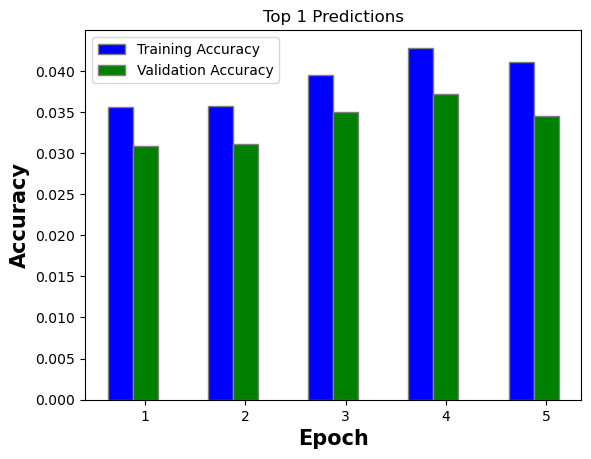

In [214]:
barWidth = 0.25
# Set position of bar on X axis
br1 = np.arange(len(epochs))
br2 = [x + barWidth for x in br1]

fig = plt.figure()
plt.bar(br1, history['train_acc'], color ='b', width = barWidth, edgecolor ='grey', label ='Training Accuracy')
plt.bar(br2, history['val_acc'], color ='g', width = barWidth, edgecolor ='grey', label ='Validation Accuracy')

plt.title("Top 1 Predictions")
plt.xlabel('Epoch', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(epochs))], epochs)
 
plt.legend()
plt.show()

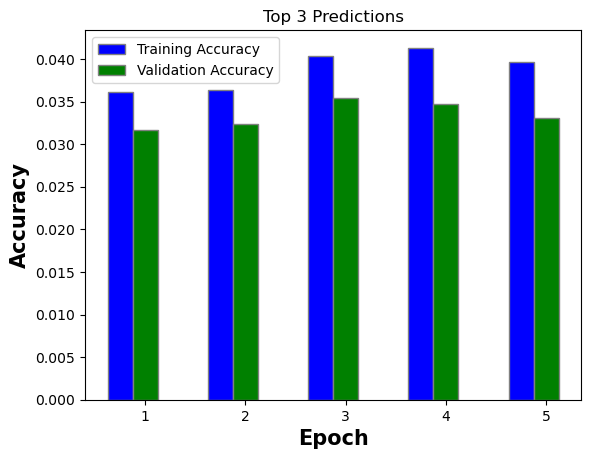

In [215]:
barWidth = 0.25
# Set position of bar on X axis
br1 = np.arange(len(epochs))
br2 = [x + barWidth for x in br1]

fig = plt.figure()
plt.bar(br1, history_top3['train_acc'], color ='b', width = barWidth, edgecolor ='grey', label ='Training Accuracy')
plt.bar(br2, history_top3['val_acc'], color ='g', width = barWidth, edgecolor ='grey', label ='Validation Accuracy')

plt.title("Top 3 Predictions")
plt.xlabel('Epoch', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(epochs))], epochs)
 
plt.legend()
plt.show()

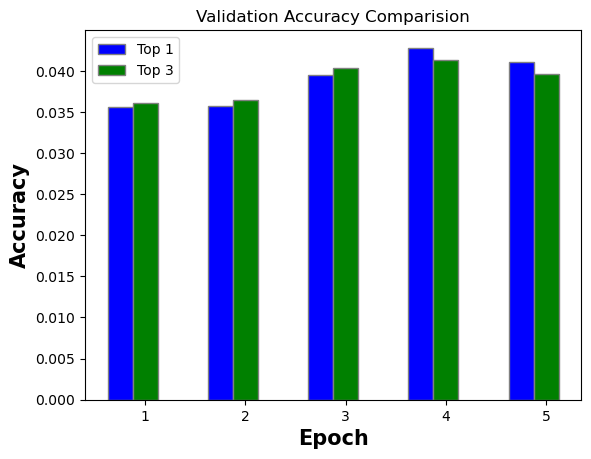

In [217]:
barWidth = 0.25
# Set position of bar on X axis
br1 = np.arange(len(epochs))
br2 = [x + barWidth for x in br1]

fig = plt.figure()
plt.bar(br1, history['train_acc'], color ='b', width = barWidth, edgecolor ='grey', label ='Top 1')
plt.bar(br2, history_top3['train_acc'], color ='g', width = barWidth, edgecolor ='grey', label ='Top 3')

plt.title("Validation Accuracy Comparision")
plt.xlabel('Epoch', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(epochs))], epochs)
 
plt.legend()
plt.show()